In [1]:
import sklearn
from pathlib import Path
import shutil
import pandas as pd

# %% Dataset configurations
DATASET_NAME = 'iris'
RANDOM_STATE = 1

train_data_path = '../data/' + DATASET_NAME + '_train.csv'
test_data_path = '../data/' + DATASET_NAME + '_test.csv'
X_train = pd.read_csv(train_data_path)
X_test = pd.read_csv(test_data_path)

y_train = X_train.pop('target')
y_test = X_test.pop('target')

# %% Temporary directories
TMP_ROOT = Path('../results/tmp') / DATASET_NAME
if TMP_ROOT.exists():
    shutil.rmtree(TMP_ROOT)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((112, 4), (38, 4), (112,), (38,))

In [2]:
from tpot import TPOTClassifier
from tpot import objectives
import time

def run_tpot(early_stop=20, max_time_mins=float('inf'), warm_start=False, search_space="linear"):
    scorer = sklearn.metrics.get_scorer('f1_weighted')

    tpot = TPOTClassifier(
        search_space=search_space,
        scorers=[scorer, objectives.complexity_scorer],
        scorers_weights=[1.0, -1.0],
        cv = 10,
        # memory= str(TMP_ROOT / 'memory'),
        preprocessing= True,
        max_time_mins=max_time_mins,
        max_eval_time_mins=10,
        n_jobs=4,
        validation_strategy='split',
        early_stop=early_stop,
        warm_start=warm_start,
        # periodic_checkpoint_folder= str(TMP_ROOT / 'checkpoints'),
        verbose=3,
        random_state=RANDOM_STATE,
        population_size=50,
    )
    start = time.time()
    tpot.fit(X_train, y_train)
    return tpot, time.time() - start

/home/joao/miniconda3/envs/tpotenv/lib/python3.10/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
import os
import sys
from datetime import datetime
from sklearn.base import clone

sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))

from metrics import evaluate_metrics
from serialize import serialize_tpot

def build_document(tpot, elapsed):
    """
    Generates a dictionary with metrics from the best models found by TPOT.
    Maintains:
      - 'pareto_complexity': metrics from lowest 'complexity_scorer' (tiebreaker by highest 'f1_score')
      - 'pareto_f1': metrics from highest 'f1_score' (tiebreaker by lowest 'complexity_scorer')
      - 'best_model': metrics from tpot.fitted_pipeline_ 
    """

    individuals = tpot.evaluated_individuals
    individuals = individuals.drop(columns=individuals.select_dtypes(include="object").columns)
    individuals = individuals.drop(columns=["validation_f1_score", "validation_complexity_scorer", "validation_start_times", "validation_end_times"])
    individuals_dict = individuals.to_dict(orient='list')

    best_model = tpot.fitted_pipeline_
    model = serialize_tpot(best_model)
    metrics = evaluate_metrics(best_model, X_test, y_test)
    metrics['complexity_scorer'] = objectives.complexity_scorer(best_model, X_test, y_test)

    # Base structure of the result
    result = {
        'timeStamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'time_spent': elapsed,
        'dataset': DATASET_NAME,
        'automl': 'tpot',
        'evaluated_individuals': individuals_dict,
        'models': {
            'fitted': model,
        },
        'metrics': {
            'fitted': metrics, 
        }   
    }
    
    # Check if valid Pareto front exists
    df = tpot.pareto_front
    if df is None or len(df) == 0:
        return result
    
    # Filter valid rows
    df_valid = df[
        df["Eval Error"].isna() &
        df["complexity_scorer"].notna() &
        df["f1_score"].notna() &
        df["Instance"].notna()
    ]
    
    if df_valid.empty:
        return result
    
    # Select and train model with lowest complexity
    best_complexity = df_valid.sort_values(["complexity_scorer", "f1_score"], ascending=[True, False]).iloc[0]
    model = clone(best_complexity["Instance"])
    model.fit(X_train, y_train)
    result['models']['pareto_complexity'] = serialize_tpot(model)
    result['metrics']['pareto_complexity'] = evaluate_metrics(model, X_test, y_test)
    result['metrics']['pareto_complexity']['complexity_scorer'] = int(best_complexity["complexity_scorer"])
    
    # Select and train model with highest F1
    best_f1 = df_valid.sort_values(["f1_score", "complexity_scorer"], ascending=[False, True]).iloc[0]
    model = clone(best_f1["Instance"])
    model.fit(X_train, y_train)
    result['models']['pareto_f1'] = serialize_tpot(model)
    result['metrics']['pareto_f1'] = evaluate_metrics(model, X_test, y_test)
    result['metrics']['pareto_f1']['complexity_scorer'] = int(best_f1["complexity_scorer"])
    
    return result, individuals

## Experiments

In [4]:
tpot, elapsed = run_tpot(early_stop=10, max_time_mins=2)

Generation: : 0it [00:00, ?it/s]/home/joao/miniconda3/envs/tpotenv/lib/python3.10/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/joao/miniconda3/envs/tpotenv/lib/python3.10/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/joao/miniconda3/envs/tpotenv/lib/python3.10/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025

Generation:  1
Best f1_score score: 0.9771428571428572
Best complexity_scorer score: 7.0


Generation: : 2it [00:53, 27.33s/it]

Generation:  2
Best f1_score score: 0.9885714285714287
Best complexity_scorer score: 6.0


Generation: : 3it [01:21, 27.63s/it]

Generation:  3
Best f1_score score: 0.9885714285714287
Best complexity_scorer score: 6.0


Generation: : 4it [01:55, 30.23s/it]

Generation:  4
Best f1_score score: 0.9885714285714287
Best complexity_scorer score: 6.0


Generation: : 5it [02:02, 24.44s/it]

Generation:  5
Best f1_score score: 0.9885714285714287
Best complexity_scorer score: 6.0


In [5]:
document, individuals = build_document(tpot, elapsed)

In [6]:
document

{'timeStamp': '2025-09-25 10:58:19',
 'time_spent': 129.67479252815247,
 'dataset': 'iris',
 'automl': 'tpot',
 'evaluated_individuals': {'f1_score': [nan,
   nan,
   nan,
   nan,
   0.9771428571428572,
   nan,
   nan,
   0.9162301587301588,
   0.9657142857142856,
   nan,
   nan,
   nan,
   0.9771428571428572,
   nan,
   0.17045454545454547,
   0.757718253968254,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   0.9771428571428572,
   nan,
   0.9771428571428572,
   0.9178571428571429,
   0.8529761904761906,
   0.9520238095238096,
   0.9542857142857144,
   0.24454545454545457,
   0.9542857142857144,
   0.9657142857142856,
   0.2263636363636364,
   nan,
   0.17045454545454547,
   nan,
   nan,
   nan,
   nan,
   nan,
   0.9428571428571428,
   nan,
   nan,
   0.9542857142857144,
   0.9771428571428572,
   0.9657142857142859,
   nan,
   0.9771428571428572,
   nan,
   0.17045454545454547,
   0.9657142857142859,
   0.9434920634920635,
   0.22787878787878793,
   0.9542857142857144,
   0.988571

In [7]:
individuals.head(5)

,f1_score,complexity_scorer,Generation,Submitted Timestamp,Completed Timestamp,Pareto_Front
0,NaN,NaN,0.0,1.758809e+09,1.758809e+09,NaN
1,NaN,NaN,0.0,1.758809e+09,1.758809e+09,NaN
2,NaN,NaN,0.0,1.758809e+09,1.758809e+09,NaN
3,NaN,NaN,0.0,1.758809e+09,1.758809e+09,NaN
4,0.977143,5125.0,0.0,1.758809e+09,1.758809e+09,NaN


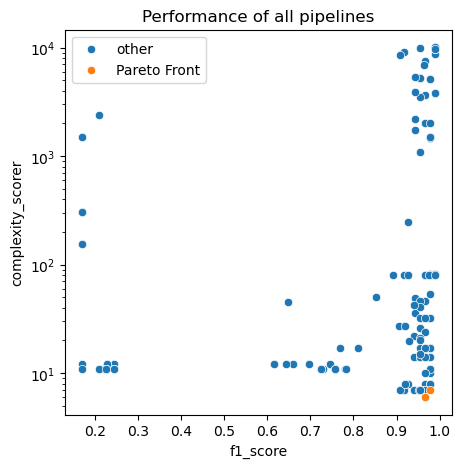

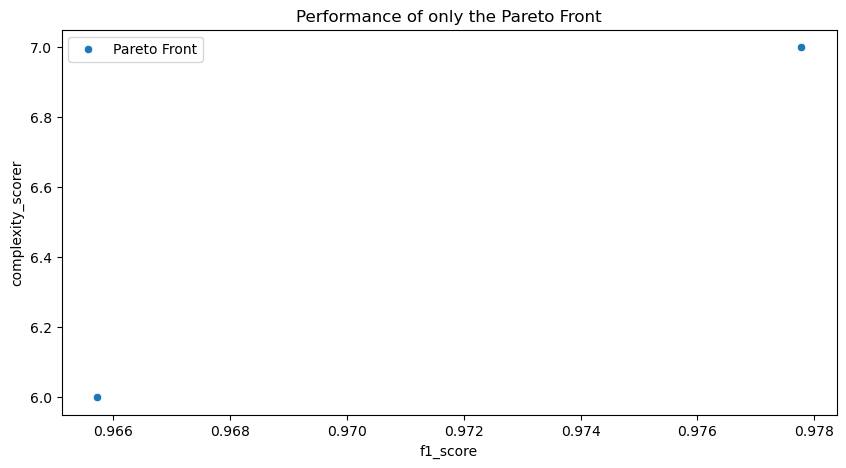

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df = individuals
metric = 'f1_score'

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(df[df['Pareto_Front']!=1], x=metric, y='complexity_scorer', label='other', ax=ax)
sns.scatterplot(df[df['Pareto_Front']==1], x=metric, y='complexity_scorer', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of all pipelines')
# log scale y
ax.set_yscale('log')
plt.show()

# replace nans in pareto front with 0
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(df[df['Pareto_Front']==1], x=metric, y='complexity_scorer', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of only the Pareto Front')
# log scale y
# ax.set_yscale('log')
plt.show()

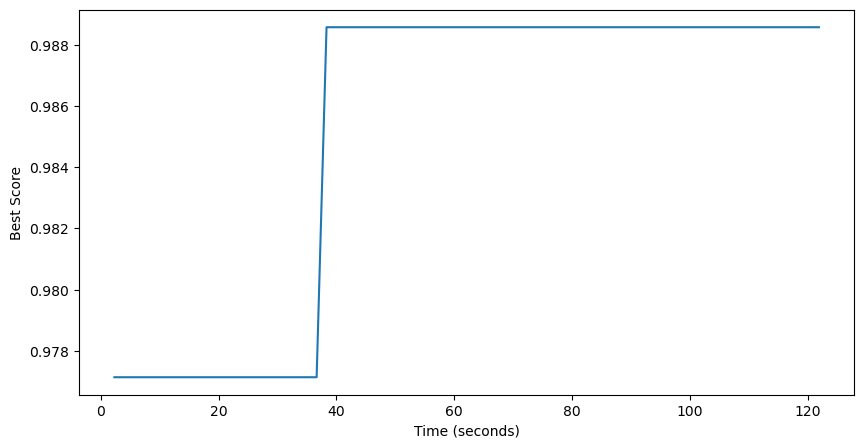

In [9]:
import numpy as np

# get columns where roc_auc_score is not NaN
scores_and_times = df[df[metric].notna()][[metric, 'Completed Timestamp']].sort_values('Completed Timestamp', ascending=True).to_numpy()

# get best score at a given time
best_scores = np.maximum.accumulate(scores_and_times[:,0])
times = scores_and_times[:,1]
times = times - df['Submitted Timestamp'].min()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(times, best_scores)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Best Score')
plt.show()

In [10]:
tpot.fitted_pipeline_

,steps,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('impute_numeric', ...)]"
,transform_input,None
,memory,None
,verbose,False
,columns,'all'
,missing_values,nan
,strategy,'mean'


In [11]:
TMP_ROOT = Path('../results/tmp') / DATASET_NAME
if TMP_ROOT.exists():
    shutil.rmtree(TMP_ROOT)